0       330627
1       334545
2       340756
3       347474
4       355279
        ...   
264    3649597
265    3650310
266    3650970
267    3651581
268    3652530
Name: Recovered, Length: 269, dtype: int64
[9.31131548e-01 1.55749861e+00 2.16010402e+00 ... 9.80799542e+02
 9.81114446e+02 9.81427840e+02]
t  (2699,), result_list (2699,)


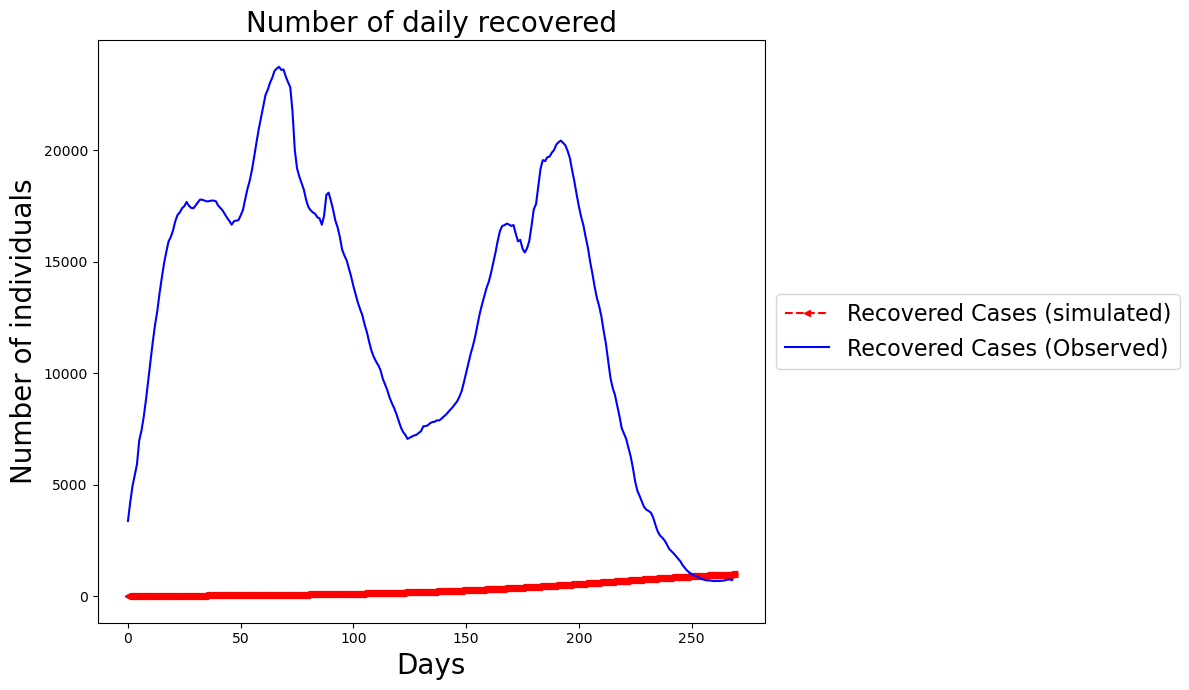

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate
from iprocessor import add_day_name_column,smooth_sundays_rolling_w7_l,add_date_name_column
from utility_intilization import get_value_by_date
#from numerical_simulation import param_dict_r as param_dict,t_fit

#---------------------------------------------
df = pd.read_csv(r'C:\Users\Evenezer kidane\PycharmProjects\MA\Ma\German_case.csv')

# -------------------------------------------------------------------------------Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# ------------------------------------------------------------------------------  Modification
# Add the 'days' column
df = add_day_name_column(df)
df = add_date_name_column(df)
print(df['Recovered'])
# ----------------------------------------------------------------------------- second modification with w7_l
df_observed = smooth_sundays_rolling_w7_l(df)

#--------------------------------------------
def derivative_rhs( X,t):
    S, E, A, I, F, R, D = X
    derivS = - contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population
    derivE = contacts * transmission_prob * S * (I + reducing_transmission * A) / total_population - E / exposed_period
    derivA = prob_asymptomatic * E / exposed_period - A / asymptomatic_period
    derivI = (
                         1 - prob_asymptomatic) * E / exposed_period + dev_symp * A / asymptomatic_period - I / infectious_period  # +
    derivF = prob_quarant_inf * I / infectious_period - F / isolated_period + test_asy * A / asymptomatic_period  # prob_isolated_asy*A/asymptomatic_period
    derivR = (1 - prob_quarant_inf - mortality_infected) * I / infectious_period + (
                1 - mortality_isolated) * F / isolated_period + (
                         1 - dev_symp - test_asy) * A / asymptomatic_period  # (1-prob_isolated_asy)*A / asymptomatic_period
    derivD = (mortality_infected) * I / infectious_period + mortality_isolated * F / isolated_period
    return np.array([derivS, derivE, derivA, derivI, derivF, derivR, derivD])



#if __name__ == "__main__":


# 2020.03.02 initialization
#exposed_value: 18633.333333333332, asymptomatic_value: 5064.0,
# infection_value: 136.89000000000001, recovered:2065, death:47, isolated:1451, susceptible:81972602.77666667
total_population = 82000000  # Total number of individuals
E0 = 18633.333333333332
A0 = 5064
I0 = 136.89
F0 = 1451
R0 = 2065
D0 = 47
S0 = total_population - E0 - A0 - I0 - F0 - R0 - D0 # Susceptible individuals


'''contacts = param_dict['contacts']
transmission_prob = param_dict['transmission_prob']
reducing_transmission = param_dict['reducing_transmission']
exposed_period = param_dict['exposed_period']
asymptomatic_period = param_dict['asymptomatic_period']
infectious_period = param_dict['infectious_period']
isolated_period = param_dict['isolated_period']
prob_asymptomatic = param_dict['prob_asymptomatic']
prob_quarant_inf = param_dict['prob_quarant_inf']
test_asy = param_dict['test_asy']
dev_symp = param_dict['dev_symp']
mortality_isolated = param_dict['mortality_isolated']
mortality_infected = param_dict['mortality_infected']'''
# ------------------------------------------------------replacing values
contacts = 0.9737
transmission_prob = 0.3154  # 0.3649
total_population = 82000000
reducing_transmission = 0.55  # 0.764
exposed_period = 5.2  #
asymptomatic_period = 7
infectious_period = 3.7
isolated_period = 12  # 11  # 11,23
prob_asymptomatic = 0.34  # 0.2
prob_quarant_inf = 0.9303  # 0.05
test_asy = 0.271  # 0.171
dev_symp = 0.125
mortality_isolated = 0.02
mortality_infected = 0.1

#tmax = t_fit  # maximum simulation day
tmax = 90#269
fslarge = 20
fssmall = 16


t_fit = df_observed['days'].max()
# Plot simulation results
t = np.linspace(0, t_fit, (t_fit +1) * 10)

fig, ax = plt.subplots(figsize=[12, 7])

#  simulated data
solution_seaifrd = integrate.odeint(derivative_rhs, [S0, E0, A0, I0, F0, R0, D0], t)
result_list = np.diff(solution_seaifrd[:, 6])#--------------------------------------applying numpy for the difference
print(result_list)
t = t[:-1]#------------------------reducing last row, as my result_list is one row shorter
print(f't  {t.shape}, result_list {result_list.shape}')
ax.plot(t, result_list, label='Recovered Cases (simulated)', linestyle='--', marker='<', color='red', markersize=4)
#print(f'simulated ,{solution_seaifrd[:, 5]}')
#storing_list = solution_seaifrd[:, 5]
#print(storing_list)

# Overlay the graph of observed confirmed cases
ax.plot(df['n_recovered'],  label='Recovered Cases (Observed)', linestyle='-', color='blue')

# title
ax.set_xlabel('Days', fontsize=fslarge)
ax.set_ylabel('Number of individuals', fontsize=fslarge)
ax.set_title('Number of daily recovered', fontsize=fslarge)

#  legend
ax.legend(fontsize=fssmall, loc='center left', bbox_to_anchor=(1, 0.5))

#  layout
plt.tight_layout()

# Show the plot
plt.show()
